# HWRS 528 IMP04
## Optimization of performance by automated calibration of parameters
### 1. Import Python packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import LRC_modelSubprograms as lrc      # Leaf River Catchment model subprograms
from scipy.optimize import minimize     # Optimization package for par optimization
import datetime as dt

### 2. Begin model simulation for Leaf River
#### 2.1 Load data, choose time period, and specify model parameters

In [7]:
#==== Load Leaf River Catchment Data as a DataFrame ===============================
LRData = pd.read_csv('../LeafRiverDaily.csv')

#==== Get a number of datapoints ==================================================
Ndata = LRData.shape[0]
Nvars = LRData.shape[1]

#==== Choose a simulation time period and set up time vector ======================
Period_Start = 0; Period_End = 365*3                # select time period to work with
Time = np.arange(0, Period_End, 1)
NTime = len(Time)

#==== Set number of initial time steps to use as spin-up ==========================
# Metrics are not computed on this period
SpinUp = 90                                         # select 90-day spin-up period

#==== Get data for the desired period =============================================
PPobs = LRData.PP[Time].to_numpy()                  # Convert from DataFrame to numpy
PEobs = LRData.PE[Time].to_numpy()                  # arrays to avoid indexing issues
QQobs = LRData.QQ[Time].to_numpy()

#==== Determine max values for each variable ======================================
PPobs_max = np.max(PPobs)
PEobs_max = np.max(PEobs)
QQobs_max = np.max(QQobs)

#==== Specify model parameters ====================================================
NRes = 2; ResIdex = np.arange(0, NRes, 1)

#==== Specify process parameter values for simulation==============================
Theta_C1  = 51.0;    # Upper Soil Zone Capacity
Theta_P1  = 0.75;     # Evapotranspiration Parameter (Reducing value increases ET)  
Theta_K12 = 0.25;    # Drainage to Lower Soil Zone (Increasing value increases Drainage) 
Theta_K13 = 0.04;    # Interflow Parameter (Increasing value increases Interflow)  
Theta_K2Q = 0.0002;  # Baseflow Parameter (Increasing value makes baseflow recessions steeper) 
Theta_K3Q = 0.56;     # Channel Routing Parameter (Increasing value reduces temporal dispersion)

Pars = np.zeros(6)

Pars[0] = Theta_C1;  Pars[1] = Theta_P1;  Pars[2] = Theta_K12
Pars[3] = Theta_K13; Pars[4] = Theta_K2Q; Pars[5] = Theta_K3Q

#### 2.2 Run catchment model for Selected time period

In [8]:
lrc.MainCatchModel(Pars, PPobs, PEobs, QQobs, NRes)

1.1373309606828417

### 3. Optimize values

In [26]:
#==== Set number of iterations for optimization =========================
NIterations = 10000

#==== Set paramter bounds ===============================================
            # Theta_C1  Theta_P1  Theta_K12  Theta_K13   Theta_K2Q    Theta_K3Q
ParBounds = [[10,200], [0.5,1.5], [0.0,0.5], [0.0,0.9], [0.0001,0.1], [0.1,0.9]]

#==== Perform optimization search =======================================
OptSearchResult = minimize(lrc.MainCatchModel, Pars, args = (PPobs, PEobs, QQobs, NRes),
                  bounds=ParBounds, method='nelder-mead',
                  options={'disp':True, 'return_all':True,'maxiter':NIterations}
                  )


Optimization terminated successfully.
         Current function value: 1.104930
         Iterations: 1782
         Function evaluations: 2700


In [ ]:
#==== Track evolution of KGEss ==========================================

ParSets = OptSearchResult['allvecs']
NParSets   = len(ParSets)
ParSetsidx = np.arange(0, NParSets, 1)
KGEss      = np.zeros(NParSets)

for i in ParSetsidx:
    Pars = ParSets[i]
    KGEss[i] = lrc.MainCatchModel(Pars, PPobs, PEobs, QQobs, NRes)**-1

plt.grid('--k')
plt.xlabel('Iterations')
plt.ylabel('KGEss value')
plt.xlim(0,NParSets)
plt.plot(KGEss)


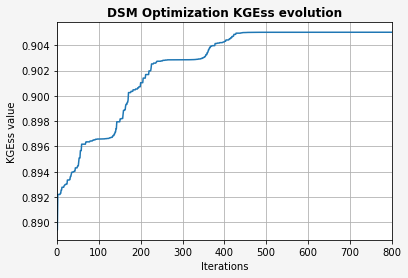

In [123]:
plt.figure(facecolor='whitesmoke')
plt.grid('--k')
plt.xlabel('Iterations')
plt.ylabel('KGEss value')
plt.xlim(0,800)
plt.title('DSM Optimization KGEss evolution', fontweight='bold')
plt.plot(KGEss[1:])

In [61]:
#==== Compile lists of parameter evolution ==============================

def ParValues(array):
    NParSets   = len(array)
    ParSetsidx = np.arange(0, NParSets, 1)

    Theta_C1List  = np.zeros(NParSets); Theta_P1List  = np.zeros(NParSets)
    Theta_K12List = np.zeros(NParSets); Theta_K13List = np.zeros(NParSets)
    Theta_K2QList = np.zeros(NParSets); Theta_K3QList = np.zeros(NParSets)

    for i in ParSetsidx:
        Theta_C1List[i]  = array[i][0]
        Theta_P1List[i]  = array[i][1]
        Theta_K12List[i] = array[i][2]
        Theta_K13List[i] = array[i][3]
        Theta_K2QList[i] = array[i][4]
        Theta_K3QList[i] = array[i][5]

    return [Theta_C1List, Theta_P1List, Theta_K12List,
            Theta_K13List, Theta_K2QList, Theta_K3QList]

# [Theta_C1List, Theta_P1List, Theta_K12List, Theta_K13List, Theta_K2QList, Theta_K3QList] = ParValues(ParSets)

In [ ]:
#==== Plot DSM optimization search for individual parameters ============

AllVectorsList = ParValues(ParSets)                         # Call parameter lists from minimize_fun output
Iter_Start = 0; Iter_End = 800                              # Set iteration range for plotting
ParNames = ['Theta_C1', 'Theta_P1', 'Theta_K12',
            'Theta_K13', 'Theta_K2Q', 'Theta_K3Q']

fig, axs = plt.subplots(nrows=3, ncols=2,                   # initialize figure and 3x2 subplots
                        figsize=(12,8),
                        sharex=True,
                        constrained_layout=True)
fig.supylabel(r'$\theta$ values',                           # set super y label
              fontsize=16,
              fontweight='bold')
fig.suptitle('Downhill Simplex Method Optimization Search', # set super title of figure
             fontsize=18,
             fontweight='bold')
fig.set_facecolor('whitesmoke')

idx = 0                                                     # initialize Parameter index value
for i in np.arange(0,3,1):                                  # iterate over rows    (3)
    for j in np.arange(0,2,1):                              # iterate over columns (2)
        ParList = AllVectorsList[idx][Iter_Start:Iter_End]  # set parameter list and truncate to 800 iterations
        ParName = ParNames[idx]                             # grab parameter name from above list
        axs[i,j].plot(ParList)
        axs[i,j].set_xlim(Iter_Start,Iter_End)      
        axs[i,j].grid('--k')
        axs[2,j].set_xlabel('Iterations')
        axs[i,j].set_title(ParName)
        idx += 1                                            # increase parameter index by one

In [4]:
#==== Save results from 2023-04-24 12:34 ================================
# Current function value: 1.104930
# result['x']
results = [7.71076000e+01, 5.00000009e-01, 4.90073149e-02, 1.87564529e-02, 1.00000000e-04, 5.76096385e-01]

In [5]:
lrc.MainCatchModel(results, PPobs, PEobs, QQobs, NRes)

1.1049302810443948